# Force the LSTM with above zero temperatures, what happens to the snow?

In [108]:
from pathlib import Path
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings 
import pandas as pd

import sys
sys.path.append("/home/tommy/neuralhydrology")
from scripts.read_nh_results import (
    get_test_filepath,
    get_all_station_ds,
    calculate_all_error_metrics,
    get_ensemble_path,
)

from scripts.read_model import (get_model, _load_weights)
from scripts.read_nh_results import (read_multi_experiment_results, calculate_member_errors)
from neuralhydrology.utils.config import Config

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
data_dir = Path("/datadrive/data")
run_dir = data_dir / "runs/ensemble_NO_EVAP/lstm_ensemble1_NO_EVAP_1606_014459"
out_dir = run_dir / "cell_states"

In [110]:
import geopandas as gpd
from scripts.geospatial import initialise_gb_spatial_plot, load_latlon_points
from mpl_toolkits.axes_grid1 import make_axes_locatable

st_data_dir = Path("/home/tommy/spatio_temporal/data")
points = load_latlon_points(st_data_dir)
static = xr.open_dataset(st_data_dir / "camels_static.nc")

In [111]:
# load config
cfg = Config(run_dir / "config.yml")
cfg.run_dir = run_dir

cfg.dynamic_inputs

['precipitation', 'temperature']

# create new forcing data

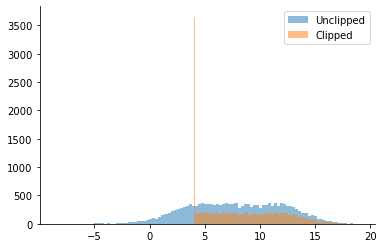

In [112]:
ds = xr.open_dataset(data_dir / "RUNOFF/ALL_dynamic_ds.nc")

if "ds" in globals().keys():
    clip_temp = 4.0
    clipped = np.clip(ds["temperature"], a_min=4, a_max=None)

    plt.hist(ds["temperature"].isel(station_id=0), bins=100, alpha=0.5, label="Unclipped");
    plt.hist(clipped.isel(station_id=0), bins=100, alpha=0.5, label="Clipped");
    plt.legend()
    sns.despine()

In [5]:
from tqdm import tqdm

# dd / "attributes"


def get_basin(file_path: Path) -> int:
    return int(file_path.name.split("timeseries_")[-1].split("_")[0])


def read_single_camelsgb_file(file_path: Path) -> pd.DataFrame:
    df = pd.read_csv(file_path, sep=',', header=0, dtype={'date': str})
    df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")
    df["basin"] = get_basin(file_path)
    df = df.set_index(["date", "basin"])
    
    return df


def load_camelsgb_xr(data_dir: Path) -> xr.Dataset:
    assert (data_dir / "timeseries").exists(), f"Expect to find timeseries folder at {data_dir.as_posix()}"
    dynamic_files = list((data_dir / "timeseries").iterdir())
    pbar = tqdm(dynamic_files, desc="Loading Basins:")
    xrs = []
    for fp in pbar:
        xrs.append(read_single_camelsgb_file(fp).to_xarray())
    
    print("Concatenating all files")
    ds = xr.concat(xrs, dim="basin")
    return ds

In [113]:
import pickle

additional_feature_files = (cfg.data_dir / "additional_feature_files.pkl")

if not additional_feature_files.exists():
    # load in the camelsGB timeseries
    ds = load_camelsgb_xr(cfg.data_dir)
    
    # create clipped temperature dict
    variable = "temperature"
    pickle_dict = {}
    pbar = tqdm(ds.basin.values, f"Clipping {variable}")
    for basin in pbar:
        pbar.set_postfix_str(f"{basin}")
        basin_clipped = clipped.sel(basin=basin).to_dataframe().drop("basin", axis=1)
        basin_clipped = basin_clipped.rename({"temperature": "temperature_clipped"}, axis=1)
        pickle_dict[str(basin)] = basin_clipped
        
    # write to pickle
    with additional_feature_files.open("wb") as fp:
        pickle.dump(pickle_dict, fp)
        
d = pickle.load(additional_feature_files.open("rb"))
assert "temperature_clipped" in d["10002"].columns

In [117]:
d = pickle.load(additional_feature_files.open("rb"))
print("Filepath: ", additional_feature_files)
print("Type: ", type(d))
print("Dict Keys: ", [k for k in d.keys()][:3])
print("Dict Values:\n", d[[k for k in d.keys()][0]].describe())

Filepath:  /datadrive/data/CAMELS_GB_DATASET/additional_feature_files.pkl
Type:  <class 'dict'>
Dict Keys:  ['10002', '10003', '1001']
Dict Values:
        temperature_clipped
count         16436.000000
mean              8.441143
std               3.785193
min               4.000000
25%               4.600000
50%               7.950000
75%              11.602500
max              19.810000


## update scaler too!

In [9]:
scaler_file = cfg.run_dir / "train_data" / "train_data_scaler.p"
with scaler_file.open('rb') as fp:
    scaler = pickle.load(fp)

if "temperature_clipped" not in scaler["xarray_feature_scale"].data_vars:
    # copy new scale/center
    scaler["xarray_feature_scale"]["temperature_clipped"] = scaler["xarray_feature_scale"]["temperature"]
    scaler["xarray_feature_center"]["temperature_clipped"] = scaler["xarray_feature_center"]["temperature"]

    with scaler_file.open('wb') as fp:
        pickle.dump(scaler, fp)
        
scaler["xarray_feature_scale"].data_vars

Data variables:
    discharge_spec       float64 3.587
    precipitation        float64 5.929
    temperature          float64 5.156
    temperature_clipped  float64 5.156

# Update cfg to use new additional feature files (no subzeros)

In [10]:
new_dynamic_inputs = [di for di in cfg.dynamic_inputs if "temperature" not in di]
new_dynamic_inputs = new_dynamic_inputs + ["temperature_clipped"]

In [11]:
from copy import deepcopy

f_cfg = deepcopy(cfg)

f_cfg._cfg["additional_feature_files"] = additional_feature_files.absolute().as_posix()
f_cfg._cfg["dynamic_inputs"] = new_dynamic_inputs

print(f_cfg.dynamic_inputs)
print(f_cfg.additional_feature_files)

['precipitation', 'temperature_clipped']
['/datadrive/data/CAMELS_GB_DATASET/additional_feature_files.pkl']


# Run forward pass of the model

In [118]:
%reload_ext autoreload
%autoreload 2

from neuralhydrology.evaluation import get_tester
from scripts.read_nh_results import _load_dict_to_xarray

preds_filepath = (run_dir / "forced_preds.nc")
if not preds_filepath.exists():
    tester = get_tester(cfg=f_cfg, run_dir=f_cfg.run_dir, period="test", init_model=True)
    results = tester.evaluate(epoch=None, save_results=False, metrics=f_cfg.metrics)
    forced_pred = _load_dict_to_xarray(results)
    forced_pred.to_netcdf(preds_filepath)
else:
    forced_pred = xr.open_dataset(preds_filepath)

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   0%|          | 1/669 [00:00<06:06,  1.82it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   0%|          | 2/669 [00:01<06:15,  1.77it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   0%|          | 3/669 [00:01<06:28,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|          | 4/669 [00:02<06:29,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|          | 5/669 [00:02<06:45,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|          | 6/669 [00:03<06:40,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|          | 7/669 [00:04<06:40,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|          | 8/669 [00:04<07:17,  1.51it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|▏         | 9/669 [00:05<07:03,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   1%|▏         | 10/669 [00:06<06:56,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 11/669 [00:06<06:48,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 12/669 [00:07<06:45,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 13/669 [00:07<06:33,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 14/669 [00:08<06:28,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 15/669 [00:09<06:44,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   2%|▏         | 16/669 [00:09<06:42,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 17/669 [00:10<06:33,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 18/669 [00:10<06:25,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 19/669 [00:11<06:21,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 20/669 [00:12<06:17,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 21/669 [00:12<06:23,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 22/669 [00:13<06:26,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   3%|▎         | 23/669 [00:13<06:29,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▎         | 24/669 [00:14<06:27,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▎         | 25/669 [00:15<06:38,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▍         | 26/669 [00:15<06:28,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▍         | 27/669 [00:16<06:19,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▍         | 28/669 [00:16<06:22,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▍         | 29/669 [00:17<06:18,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   4%|▍         | 30/669 [00:18<06:15,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▍         | 31/669 [00:18<06:18,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▍         | 32/669 [00:19<06:21,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▍         | 33/669 [00:19<06:22,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▌         | 34/669 [00:20<06:24,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▌         | 35/669 [00:21<06:48,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   5%|▌         | 36/669 [00:21<06:32,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▌         | 37/669 [00:22<06:31,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▌         | 38/669 [00:22<06:15,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▌         | 39/669 [00:23<06:10,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▌         | 40/669 [00:24<06:08,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▌         | 41/669 [00:24<06:10,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▋         | 42/669 [00:25<06:13,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   6%|▋         | 43/669 [00:25<06:15,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 44/669 [00:26<06:16,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 45/669 [00:27<06:41,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 46/669 [00:27<06:31,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 47/669 [00:28<06:23,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 48/669 [00:29<06:22,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 49/669 [00:29<06:16,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   7%|▋         | 50/669 [00:30<06:16,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 51/669 [00:30<06:16,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 52/669 [00:31<06:17,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 53/669 [00:32<06:17,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 54/669 [00:32<06:16,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 55/669 [00:33<06:27,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   8%|▊         | 56/669 [00:34<08:18,  1.23it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▊         | 57/669 [00:35<09:25,  1.08it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▊         | 58/669 [00:36<08:23,  1.21it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▉         | 59/669 [00:37<07:43,  1.32it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▉         | 60/669 [00:37<07:03,  1.44it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▉         | 61/669 [00:38<06:47,  1.49it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▉         | 62/669 [00:38<06:33,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:   9%|▉         | 63/669 [00:39<06:19,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|▉         | 64/669 [00:39<06:16,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|▉         | 65/669 [00:40<06:36,  1.52it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|▉         | 66/669 [00:41<06:17,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|█         | 67/669 [00:41<06:06,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|█         | 68/669 [00:42<05:43,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|█         | 69/669 [00:42<05:48,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  10%|█         | 70/669 [00:43<05:44,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█         | 71/669 [00:44<05:39,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█         | 72/669 [00:44<05:46,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█         | 73/669 [00:45<05:51,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█         | 74/669 [00:45<05:54,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█         | 75/669 [00:46<05:59,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  11%|█▏        | 76/669 [00:47<05:59,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 77/669 [00:47<05:45,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 78/669 [00:48<05:51,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 79/669 [00:48<05:36,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 80/669 [00:49<05:42,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 81/669 [00:49<05:46,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 82/669 [00:50<05:50,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  12%|█▏        | 83/669 [00:51<05:51,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 84/669 [00:51<05:50,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 85/669 [00:52<06:11,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 86/669 [00:53<06:05,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 87/669 [00:53<06:01,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 88/669 [00:54<05:58,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 89/669 [00:54<05:56,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  13%|█▎        | 90/669 [00:55<05:55,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▎        | 91/669 [00:56<05:54,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 92/669 [00:56<05:34,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 93/669 [00:57<05:28,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 94/669 [00:57<05:27,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 95/669 [00:58<05:56,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 96/669 [00:59<05:53,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  14%|█▍        | 97/669 [00:59<05:51,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▍        | 98/669 [01:00<05:46,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▍        | 99/669 [01:00<05:46,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▍        | 100/669 [01:01<05:38,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▌        | 101/669 [01:02<05:40,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▌        | 102/669 [01:02<05:41,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  15%|█▌        | 103/669 [01:03<05:42,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▌        | 104/669 [01:03<05:43,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▌        | 105/669 [01:05<09:17,  1.01it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▌        | 106/669 [01:06<08:10,  1.15it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▌        | 107/669 [01:07<07:24,  1.27it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▌        | 108/669 [01:07<06:52,  1.36it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▋        | 109/669 [01:08<06:23,  1.46it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  16%|█▋        | 110/669 [01:08<06:11,  1.50it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 111/669 [01:09<06:03,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 112/669 [01:10<05:55,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 113/669 [01:10<05:50,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 114/669 [01:11<05:47,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 115/669 [01:12<06:02,  1.53it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 116/669 [01:12<05:55,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  17%|█▋        | 117/669 [01:13<05:49,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 118/669 [01:13<05:40,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 119/669 [01:14<05:37,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 120/669 [01:15<05:35,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 121/669 [01:15<05:34,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 122/669 [01:16<05:33,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  18%|█▊        | 123/669 [01:16<05:20,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▊        | 124/669 [01:17<05:22,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▊        | 125/669 [01:18<05:36,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▉        | 126/669 [01:18<05:31,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▉        | 127/669 [01:19<05:25,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▉        | 128/669 [01:19<05:26,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▉        | 129/669 [01:20<05:27,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  19%|█▉        | 130/669 [01:21<05:27,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|█▉        | 131/669 [01:21<05:27,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|█▉        | 132/669 [01:22<05:13,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|█▉        | 133/669 [01:22<05:08,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|██        | 134/669 [01:23<05:03,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|██        | 135/669 [01:23<05:12,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|██        | 136/669 [01:24<05:10,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  20%|██        | 137/669 [01:25<05:05,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██        | 138/669 [01:25<05:06,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██        | 139/669 [01:26<04:53,  1.80it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██        | 140/669 [01:26<04:47,  1.84it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██        | 141/669 [01:27<04:57,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██        | 142/669 [01:27<05:04,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  21%|██▏       | 143/669 [01:28<05:09,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 144/669 [01:29<05:08,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 145/669 [01:29<05:17,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 146/669 [01:30<05:16,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 147/669 [01:30<05:09,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 148/669 [01:31<05:03,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 149/669 [01:32<04:58,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  22%|██▏       | 150/669 [01:32<05:01,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 151/669 [01:33<04:42,  1.84it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 152/669 [01:33<04:43,  1.83it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 153/669 [01:34<04:45,  1.81it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 154/669 [01:34<04:54,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 155/669 [01:35<05:18,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 156/669 [01:36<05:17,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  23%|██▎       | 157/669 [01:36<05:15,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▎       | 158/669 [01:37<05:14,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▍       | 159/669 [01:37<05:04,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▍       | 160/669 [01:38<04:57,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▍       | 161/669 [01:39<05:02,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▍       | 162/669 [01:39<05:01,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  24%|██▍       | 163/669 [01:40<05:03,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▍       | 164/669 [01:40<05:05,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▍       | 165/669 [01:41<05:20,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▍       | 166/669 [01:42<05:15,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▍       | 167/669 [01:42<05:13,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▌       | 168/669 [01:43<05:07,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▌       | 169/669 [01:44<05:06,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  25%|██▌       | 170/669 [01:44<05:05,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▌       | 171/669 [01:45<05:04,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▌       | 172/669 [01:45<05:04,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▌       | 173/669 [01:46<05:03,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▌       | 174/669 [01:47<04:56,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▌       | 175/669 [01:47<05:16,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▋       | 176/669 [01:48<04:51,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  26%|██▋       | 177/669 [01:48<04:44,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 178/669 [01:49<04:42,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 179/669 [01:50<04:47,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 180/669 [01:50<04:49,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 181/669 [01:51<04:51,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 182/669 [01:51<04:52,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  27%|██▋       | 183/669 [01:52<04:44,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 184/669 [01:53<04:49,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 185/669 [01:53<05:03,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 186/669 [01:54<05:00,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 187/669 [01:54<04:58,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 188/669 [01:55<04:57,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 189/669 [01:56<05:06,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  28%|██▊       | 190/669 [01:56<04:46,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▊       | 191/669 [01:57<04:42,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▊       | 192/669 [01:57<04:35,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▉       | 193/669 [01:58<04:41,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▉       | 194/669 [01:59<04:43,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▉       | 195/669 [01:59<05:05,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▉       | 196/669 [02:00<04:59,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  29%|██▉       | 197/669 [02:01<04:48,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|██▉       | 198/669 [02:01<04:42,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|██▉       | 199/669 [02:02<04:40,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|██▉       | 200/669 [02:02<04:39,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|███       | 201/669 [02:03<04:40,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|███       | 202/669 [02:03<04:41,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|███       | 203/669 [02:04<04:40,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  30%|███       | 204/669 [02:05<04:40,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███       | 205/669 [02:05<04:58,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███       | 206/669 [02:06<04:53,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███       | 207/669 [02:07<04:49,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███       | 208/669 [02:07<04:46,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███       | 209/669 [02:08<04:42,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  31%|███▏      | 210/669 [02:08<04:28,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 211/669 [02:09<04:17,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 212/669 [02:10<04:24,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 213/669 [02:10<04:28,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 214/669 [02:11<04:27,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 215/669 [02:11<04:40,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 216/669 [02:12<04:27,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  32%|███▏      | 217/669 [02:12<04:19,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 218/669 [02:13<04:11,  1.79it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 219/669 [02:14<04:17,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 220/669 [02:14<04:21,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 221/669 [02:15<04:24,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 222/669 [02:15<04:26,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 223/669 [02:16<04:27,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  33%|███▎      | 224/669 [02:17<04:26,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▎      | 225/669 [02:17<04:36,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▍      | 226/669 [02:18<04:26,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▍      | 227/669 [02:18<04:27,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▍      | 228/669 [02:19<04:21,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▍      | 229/669 [02:20<04:18,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  34%|███▍      | 230/669 [02:20<04:15,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▍      | 231/669 [02:21<04:10,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▍      | 232/669 [02:21<04:06,  1.77it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▍      | 233/669 [02:22<04:12,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▍      | 234/669 [02:22<04:15,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▌      | 235/669 [02:23<04:33,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▌      | 236/669 [02:24<04:27,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  35%|███▌      | 237/669 [02:24<04:21,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▌      | 238/669 [02:25<04:21,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▌      | 239/669 [02:26<04:21,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▌      | 240/669 [02:26<04:21,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▌      | 241/669 [02:27<04:21,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▌      | 242/669 [02:27<04:17,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▋      | 243/669 [02:28<04:14,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  36%|███▋      | 244/669 [02:29<04:12,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 245/669 [02:29<04:25,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 246/669 [02:30<04:19,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 247/669 [02:30<04:18,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 248/669 [02:31<04:13,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 249/669 [02:32<04:13,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  37%|███▋      | 250/669 [02:32<04:09,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 251/669 [02:33<03:52,  1.80it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 252/669 [02:33<03:50,  1.81it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 253/669 [02:34<03:56,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 254/669 [02:34<03:52,  1.79it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 255/669 [02:35<04:12,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 256/669 [02:36<04:12,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  38%|███▊      | 257/669 [02:36<04:11,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▊      | 258/669 [02:37<03:56,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▊      | 259/669 [02:37<03:57,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▉      | 260/669 [02:38<04:01,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▉      | 261/669 [02:39<04:03,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▉      | 262/669 [02:39<04:05,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▉      | 263/669 [02:40<04:06,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  39%|███▉      | 264/669 [02:40<04:00,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|███▉      | 265/669 [02:41<04:07,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|███▉      | 266/669 [02:42<04:06,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|███▉      | 267/669 [02:42<03:59,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|████      | 268/669 [02:43<04:01,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|████      | 269/669 [02:43<04:01,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  40%|████      | 270/669 [02:44<04:01,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████      | 271/669 [02:45<04:00,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████      | 272/669 [02:45<03:59,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████      | 273/669 [02:46<03:57,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████      | 274/669 [02:47<03:58,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████      | 275/669 [02:47<04:12,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████▏     | 276/669 [02:48<04:08,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  41%|████▏     | 277/669 [02:48<04:05,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 278/669 [02:49<03:55,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 279/669 [02:50<03:52,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 280/669 [02:50<03:42,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 281/669 [02:51<03:42,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 282/669 [02:51<03:46,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 283/669 [02:52<03:46,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  42%|████▏     | 284/669 [02:52<03:34,  1.79it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 285/669 [02:53<03:51,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 286/669 [02:54<03:51,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 287/669 [02:54<03:52,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 288/669 [02:55<03:51,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 289/669 [02:56<03:49,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 290/669 [02:56<03:45,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  43%|████▎     | 291/669 [02:57<03:44,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▎     | 292/669 [02:57<03:46,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▍     | 293/669 [02:58<03:45,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▍     | 294/669 [02:58<03:45,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▍     | 295/669 [02:59<03:53,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▍     | 296/669 [03:00<03:52,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  44%|████▍     | 297/669 [03:00<03:50,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▍     | 298/669 [03:01<03:49,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▍     | 299/669 [03:02<03:47,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▍     | 300/669 [03:02<03:47,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▍     | 301/669 [03:03<03:47,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▌     | 302/669 [03:03<03:39,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▌     | 303/669 [03:04<03:36,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  45%|████▌     | 304/669 [03:05<03:33,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▌     | 305/669 [03:05<03:48,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▌     | 306/669 [03:06<03:45,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▌     | 307/669 [03:07<03:44,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▌     | 308/669 [03:07<03:34,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▌     | 309/669 [03:08<03:35,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▋     | 310/669 [03:08<03:34,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  46%|████▋     | 311/669 [03:09<03:30,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 312/669 [03:09<03:30,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 313/669 [03:10<03:32,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 314/669 [03:11<03:33,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 315/669 [03:11<03:46,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 316/669 [03:12<03:43,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  47%|████▋     | 317/669 [03:13<03:40,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 318/669 [03:13<03:36,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 319/669 [03:14<03:31,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 320/669 [03:14<03:28,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 321/669 [03:15<03:29,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 322/669 [03:16<03:29,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 323/669 [03:16<03:25,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  48%|████▊     | 324/669 [03:17<03:26,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▊     | 325/669 [03:17<03:38,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▊     | 326/669 [03:18<03:35,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▉     | 327/669 [03:19<03:29,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▉     | 328/669 [03:19<03:29,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▉     | 329/669 [03:20<03:28,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▉     | 330/669 [03:21<03:27,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  49%|████▉     | 331/669 [03:21<03:27,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|████▉     | 332/669 [03:22<03:26,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|████▉     | 333/669 [03:22<03:24,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|████▉     | 334/669 [03:23<03:25,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|█████     | 335/669 [03:24<03:30,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|█████     | 336/669 [03:24<03:18,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  50%|█████     | 337/669 [03:25<03:19,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████     | 338/669 [03:26<03:53,  1.42it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████     | 339/669 [03:26<03:44,  1.47it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████     | 340/669 [03:27<03:32,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████     | 341/669 [03:27<03:20,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████     | 342/669 [03:28<03:16,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████▏    | 343/669 [03:29<03:16,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  51%|█████▏    | 344/669 [03:29<03:16,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 345/669 [03:30<03:52,  1.40it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 346/669 [03:31<03:39,  1.47it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 347/669 [03:31<03:32,  1.51it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 348/669 [03:32<03:26,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 349/669 [03:33<03:22,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 350/669 [03:33<03:15,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  52%|█████▏    | 351/669 [03:34<03:07,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 352/669 [03:34<03:06,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 353/669 [03:35<02:59,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 354/669 [03:35<02:51,  1.84it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 355/669 [03:36<03:01,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 356/669 [03:37<03:03,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  53%|█████▎    | 357/669 [03:37<03:01,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▎    | 358/669 [03:38<03:04,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▎    | 359/669 [03:38<03:05,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▍    | 360/669 [03:39<03:05,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▍    | 361/669 [03:40<03:05,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▍    | 362/669 [03:40<03:06,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▍    | 363/669 [03:41<03:05,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  54%|█████▍    | 364/669 [03:41<03:05,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▍    | 365/669 [03:42<03:16,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▍    | 366/669 [03:43<03:09,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▍    | 367/669 [03:43<03:06,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▌    | 368/669 [03:44<03:04,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▌    | 369/669 [03:45<03:03,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▌    | 370/669 [03:45<02:53,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  55%|█████▌    | 371/669 [03:46<02:49,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▌    | 372/669 [03:46<03:11,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▌    | 373/669 [03:47<03:29,  1.41it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▌    | 374/669 [03:48<03:19,  1.48it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▌    | 375/669 [03:48<03:12,  1.53it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▌    | 376/669 [03:49<03:05,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  56%|█████▋    | 377/669 [03:50<02:54,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 378/669 [03:50<02:54,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 379/669 [03:51<02:53,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 380/669 [03:51<02:54,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 381/669 [03:52<02:54,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 382/669 [03:53<02:55,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 383/669 [03:53<02:50,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  57%|█████▋    | 384/669 [03:54<02:45,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 385/669 [03:54<02:57,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 386/669 [03:55<02:56,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 387/669 [03:56<02:54,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 388/669 [03:56<02:53,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 389/669 [03:57<02:52,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 390/669 [03:58<02:51,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  58%|█████▊    | 391/669 [03:58<02:48,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▊    | 392/669 [03:59<02:42,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▊    | 393/669 [03:59<02:44,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▉    | 394/669 [04:00<02:41,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▉    | 395/669 [04:01<02:51,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▉    | 396/669 [04:01<02:49,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▉    | 397/669 [04:03<03:49,  1.19it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  59%|█████▉    | 398/669 [04:03<03:28,  1.30it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|█████▉    | 399/669 [04:04<03:14,  1.39it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|█████▉    | 400/669 [04:04<03:03,  1.47it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|█████▉    | 401/669 [04:05<02:54,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|██████    | 402/669 [04:06<02:50,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|██████    | 403/669 [04:06<03:05,  1.43it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  60%|██████    | 404/669 [04:07<02:51,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████    | 405/669 [04:08<02:51,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████    | 406/669 [04:08<02:41,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████    | 407/669 [04:09<02:36,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████    | 408/669 [04:09<02:37,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████    | 409/669 [04:10<02:34,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████▏   | 410/669 [04:10<02:34,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  61%|██████▏   | 411/669 [04:11<02:30,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 412/669 [04:12<02:30,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 413/669 [04:12<02:24,  1.77it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 414/669 [04:13<02:27,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 415/669 [04:13<02:39,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 416/669 [04:14<02:37,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 417/669 [04:15<02:32,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  62%|██████▏   | 418/669 [04:15<02:29,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 419/669 [04:16<02:19,  1.79it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 420/669 [04:16<02:18,  1.80it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 421/669 [04:17<02:19,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 422/669 [04:17<02:22,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 423/669 [04:18<02:19,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  63%|██████▎   | 424/669 [04:18<02:10,  1.88it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▎   | 425/669 [04:19<02:23,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▎   | 426/669 [04:20<02:20,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▍   | 427/669 [04:20<02:18,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▍   | 428/669 [04:21<02:17,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▍   | 429/669 [04:21<02:16,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▍   | 430/669 [04:22<02:18,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  64%|██████▍   | 431/669 [04:23<02:19,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▍   | 432/669 [04:23<02:19,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▍   | 433/669 [04:24<02:17,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▍   | 434/669 [04:24<02:18,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▌   | 435/669 [04:25<02:26,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▌   | 436/669 [04:26<02:22,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▌   | 437/669 [04:26<02:19,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  65%|██████▌   | 438/669 [04:27<02:12,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▌   | 439/669 [04:27<02:14,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▌   | 440/669 [04:28<02:15,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▌   | 441/669 [04:28<02:12,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▌   | 442/669 [04:29<02:13,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▌   | 443/669 [04:30<02:14,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  66%|██████▋   | 444/669 [04:30<02:15,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 445/669 [04:31<02:23,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 446/669 [04:32<02:19,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 447/669 [04:32<02:18,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 448/669 [04:33<02:14,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 449/669 [04:33<02:14,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 450/669 [04:34<02:13,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  67%|██████▋   | 451/669 [04:35<02:12,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 452/669 [04:35<02:12,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 453/669 [04:36<02:11,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 454/669 [04:36<02:10,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 455/669 [04:37<02:19,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 456/669 [04:38<02:15,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 457/669 [04:38<02:13,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  68%|██████▊   | 458/669 [04:39<02:10,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▊   | 459/669 [04:40<02:03,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▉   | 460/669 [04:40<02:04,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▉   | 461/669 [04:41<02:03,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▉   | 462/669 [04:41<02:01,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▉   | 463/669 [04:42<02:02,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  69%|██████▉   | 464/669 [04:43<02:02,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|██████▉   | 465/669 [04:43<02:09,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|██████▉   | 466/669 [04:44<02:06,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|██████▉   | 467/669 [04:44<02:03,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|██████▉   | 468/669 [04:45<02:01,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|███████   | 469/669 [04:46<01:58,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|███████   | 470/669 [04:46<01:56,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  70%|███████   | 471/669 [04:47<01:51,  1.77it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████   | 472/669 [04:47<01:50,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████   | 473/669 [04:48<01:50,  1.77it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████   | 474/669 [04:48<01:49,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████   | 475/669 [04:49<02:00,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████   | 476/669 [04:50<01:59,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████▏  | 477/669 [04:50<01:56,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  71%|███████▏  | 478/669 [04:51<01:55,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 479/669 [04:51<01:53,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 480/669 [04:52<01:47,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 481/669 [04:53<01:47,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 482/669 [04:53<01:47,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 483/669 [04:54<01:47,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 484/669 [04:54<01:42,  1.81it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  72%|███████▏  | 485/669 [04:55<01:50,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 486/669 [04:55<01:45,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 487/669 [04:56<01:46,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 488/669 [04:57<01:47,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 489/669 [04:57<01:44,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 490/669 [04:58<01:43,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  73%|███████▎  | 491/669 [04:58<01:41,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▎  | 492/669 [04:59<01:42,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▎  | 493/669 [05:00<01:43,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▍  | 494/669 [05:00<01:42,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▍  | 495/669 [05:01<01:48,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▍  | 496/669 [05:01<01:44,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▍  | 497/669 [05:02<01:41,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  74%|███████▍  | 498/669 [05:03<01:42,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▍  | 499/669 [05:03<01:42,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▍  | 500/669 [05:04<01:42,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▍  | 501/669 [05:04<01:41,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▌  | 502/669 [05:05<01:40,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▌  | 503/669 [05:06<01:37,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▌  | 504/669 [05:06<01:34,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  75%|███████▌  | 505/669 [05:07<01:39,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▌  | 506/669 [05:07<01:39,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▌  | 507/669 [05:08<01:35,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▌  | 508/669 [05:09<01:35,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▌  | 509/669 [05:09<01:35,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▌  | 510/669 [05:10<01:35,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  76%|███████▋  | 511/669 [05:10<01:35,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 512/669 [05:11<01:33,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 513/669 [05:12<01:32,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 514/669 [05:12<01:32,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 515/669 [05:13<01:35,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 516/669 [05:13<01:32,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 517/669 [05:14<01:32,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  77%|███████▋  | 518/669 [05:15<01:27,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 519/669 [05:15<01:27,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 520/669 [05:16<01:28,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 521/669 [05:16<01:28,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 522/669 [05:17<01:28,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 523/669 [05:18<01:28,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 524/669 [05:18<01:28,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  78%|███████▊  | 525/669 [05:19<01:30,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▊  | 526/669 [05:19<01:27,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▉  | 527/669 [05:20<01:25,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▉  | 528/669 [05:21<01:24,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▉  | 529/669 [05:21<01:24,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▉  | 530/669 [05:22<01:24,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  79%|███████▉  | 531/669 [05:22<01:22,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|███████▉  | 532/669 [05:23<01:21,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|███████▉  | 533/669 [05:24<01:18,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|███████▉  | 534/669 [05:24<01:19,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|███████▉  | 535/669 [05:25<01:24,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|████████  | 536/669 [05:25<01:20,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|████████  | 537/669 [05:26<01:20,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  80%|████████  | 538/669 [05:27<01:20,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████  | 539/669 [05:27<01:18,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████  | 540/669 [05:28<01:18,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████  | 541/669 [05:28<01:17,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████  | 542/669 [05:29<01:17,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████  | 543/669 [05:30<01:16,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████▏ | 544/669 [05:30<01:15,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  81%|████████▏ | 545/669 [05:31<01:17,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 546/669 [05:31<01:13,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 547/669 [05:32<01:13,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 548/669 [05:33<01:09,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 549/669 [05:33<01:08,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 550/669 [05:34<01:09,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  82%|████████▏ | 551/669 [05:34<01:09,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 552/669 [05:35<01:10,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 553/669 [05:36<01:09,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 554/669 [05:36<01:09,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 555/669 [05:37<01:13,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 556/669 [05:38<01:10,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 557/669 [05:38<01:09,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  83%|████████▎ | 558/669 [05:39<01:08,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▎ | 559/669 [05:39<01:05,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▎ | 560/669 [05:40<01:03,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▍ | 561/669 [05:40<01:02,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▍ | 562/669 [05:41<01:01,  1.75it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▍ | 563/669 [05:42<00:59,  1.78it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▍ | 564/669 [05:42<01:00,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  84%|████████▍ | 565/669 [05:43<01:02,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▍ | 566/669 [05:43<01:01,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▍ | 567/669 [05:44<01:01,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▍ | 568/669 [05:45<01:01,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▌ | 569/669 [05:45<00:59,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▌ | 570/669 [05:46<00:59,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  85%|████████▌ | 571/669 [05:46<00:57,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 572/669 [05:47<00:55,  1.76it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 573/669 [05:47<00:53,  1.79it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 574/669 [05:48<00:51,  1.83it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 575/669 [05:49<00:56,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 576/669 [05:49<00:56,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▌ | 577/669 [05:50<00:54,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  86%|████████▋ | 578/669 [05:50<00:53,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 579/669 [05:51<00:53,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 580/669 [05:52<00:52,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 581/669 [05:52<00:51,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 582/669 [05:53<00:51,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 583/669 [05:53<00:51,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 584/669 [05:54<00:51,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  87%|████████▋ | 585/669 [05:55<00:52,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 586/669 [05:55<00:48,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 587/669 [05:56<00:48,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 588/669 [05:56<00:48,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 589/669 [05:57<00:48,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 590/669 [05:58<00:47,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 591/669 [05:58<00:47,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  88%|████████▊ | 592/669 [05:59<00:46,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▊ | 593/669 [05:59<00:46,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▉ | 594/669 [06:00<00:45,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▉ | 595/669 [06:01<00:46,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▉ | 596/669 [06:01<00:45,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▉ | 597/669 [06:02<00:43,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  89%|████████▉ | 598/669 [06:03<00:43,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|████████▉ | 599/669 [06:03<00:42,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|████████▉ | 600/669 [06:04<00:42,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|████████▉ | 601/669 [06:04<00:41,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|████████▉ | 602/669 [06:05<00:40,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|█████████ | 603/669 [06:06<00:40,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|█████████ | 604/669 [06:06<00:39,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  90%|█████████ | 605/669 [06:07<00:41,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████ | 606/669 [06:08<00:39,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████ | 607/669 [06:08<00:38,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████ | 608/669 [06:09<00:37,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████ | 609/669 [06:09<00:36,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████ | 610/669 [06:10<00:34,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████▏| 611/669 [06:10<00:33,  1.74it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  91%|█████████▏| 612/669 [06:11<00:33,  1.71it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 613/669 [06:12<00:32,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 614/669 [06:12<00:32,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 615/669 [06:13<00:34,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 616/669 [06:14<00:33,  1.58it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 617/669 [06:14<00:32,  1.60it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  92%|█████████▏| 618/669 [06:15<00:31,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 619/669 [06:15<00:30,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 620/669 [06:16<00:30,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 621/669 [06:17<00:29,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 622/669 [06:17<00:28,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 623/669 [06:18<00:27,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 624/669 [06:18<00:26,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  93%|█████████▎| 625/669 [06:19<00:27,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▎| 626/669 [06:20<00:26,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▎| 627/669 [06:20<00:25,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▍| 628/669 [06:21<00:24,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▍| 629/669 [06:21<00:23,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▍| 630/669 [06:22<00:23,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▍| 631/669 [06:23<00:23,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  94%|█████████▍| 632/669 [06:23<00:22,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▍| 633/669 [06:24<00:21,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▍| 634/669 [06:25<00:21,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▍| 635/669 [06:25<00:21,  1.55it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▌| 636/669 [06:26<00:21,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▌| 637/669 [06:26<00:20,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  95%|█████████▌| 638/669 [06:27<00:19,  1.61it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▌| 639/669 [06:28<00:18,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▌| 640/669 [06:28<00:17,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▌| 641/669 [06:29<00:16,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▌| 642/669 [06:29<00:16,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▌| 643/669 [06:30<00:15,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▋| 644/669 [06:31<00:15,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  96%|█████████▋| 645/669 [06:31<00:15,  1.54it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 646/669 [06:32<00:14,  1.56it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 647/669 [06:33<00:13,  1.59it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 648/669 [06:33<00:12,  1.62it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 649/669 [06:34<00:12,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 650/669 [06:34<00:11,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 651/669 [06:35<00:10,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  97%|█████████▋| 652/669 [06:36<00:10,  1.68it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 653/669 [06:36<00:09,  1.67it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 654/669 [06:37<00:09,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 655/669 [06:38<00:08,  1.57it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 656/669 [06:38<00:07,  1.63it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 657/669 [06:39<00:07,  1.64it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  98%|█████████▊| 658/669 [06:39<00:06,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▊| 659/669 [06:40<00:06,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▊| 660/669 [06:41<00:05,  1.65it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▉| 661/669 [06:41<00:04,  1.66it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▉| 662/669 [06:42<00:04,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▉| 663/669 [06:42<00:03,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▉| 664/669 [06:43<00:02,  1.73it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation:  99%|█████████▉| 665/669 [06:43<00:02,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation: 100%|█████████▉| 666/669 [06:44<00:01,  1.72it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation: 100%|█████████▉| 667/669 [06:45<00:01,  1.69it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation: 100%|█████████▉| 668/669 [06:45<00:00,  1.70it/s]

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


# Evaluation: 100%|██████████| 669/669 [06:46<00:00,  1.65it/s]

 33%|███▎      | 218/669 [00:00<00:00, 2174.58it/s]

100%|██████████| 669/669 [00:00<00:00, 2156.92it/s]


In [14]:
forced_pred

<xarray.Dataset>
Dimensions:             (date: 4018, station_id: 669)
Coordinates:
  * station_id          (station_id) <U6 '10002' '10003' ... '96004' '97002'
  * date                (date) datetime64[ns] 1998-01-01 ... 2008-12-31
Data variables:
    discharge_spec_obs  (station_id, date) float64 2.37 2.49 2.42 ... 0.73 0.79
    discharge_spec_sim  (station_id, date) float64 2.055 2.493 ... 0.8569 0.822

### check the loaded data

In [18]:
basin = 4003

In [19]:
tester = get_tester(cfg=f_cfg, run_dir=f_cfg.run_dir, period="test", init_model=True)
data = tester._get_dataset(str(basin))

temp_clipped = data.x_d[str(basin)]["1D"][:, -1]
# unnormalize
temp_clipped = (
    temp_clipped * data.scaler["xarray_feature_scale"]["temperature_clipped"].values
) + data.scaler["xarray_feature_center"]["temperature_clipped"].values


/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


In [20]:
og_tester = get_tester(cfg=cfg, run_dir=cfg.run_dir, period="test", init_model=True)
og_data = og_tester._get_dataset(str(basin))

og_temp_clipped = og_data.x_d[str(basin)]["1D"][:, -1]
# unnormalize
og_temp_clipped = (
    og_temp_clipped * data.scaler["xarray_feature_scale"]["temperature_clipped"].values
) + data.scaler["xarray_feature_center"]["temperature_clipped"].values


/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


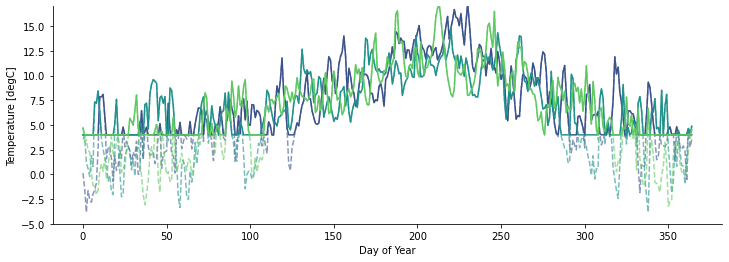

In [21]:
f, ax = plt.subplots(figsize=(12, 4))
colors = sns.color_palette("viridis", 3)
for n in np.arange(3):
    ax.plot(np.arange(365), og_temp_clipped[(365*n): 365*(n + 1)], color=colors[n], label=f"Year{n}", ls="--", alpha=0.6)
    ax.plot(np.arange(365), temp_clipped[(365*n): 365*(n + 1)], color=colors[n], label=f"Year{n}")

ax.set_xlabel("Day of Year")
ax.set_ylabel("Temperature [degC]")
ax.set_ylim(-5, 17)
sns.despine()

# Extract cell states

In [23]:
# [f.name for f in list(out_dir.iterdir())]

In [24]:
from scripts.cell_state.extract_cell_state import get_cell_states

out_dir = run_dir / "cell_states_hi_temp"

if not out_dir.exists():
    out_dir.mkdir(parents=True, exist_ok=True)

if not (out_dir / "cell_states.nc").exists():
    cn = get_cell_states(f_cfg, run_dir)
    cn.to_netcdf(out_dir / "cell_states.nc")
else:
    cn = xr.open_dataset(out_dir / "cell_states.nc")

/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",


Using the model weights from /datadrive/data/runs/ensemble_NO_EVAP/lstm_ensemble1_NO_EVAP_1606_014459/model_epoch030.pt


Extracting cell state for basin:   0%|          | 1/669 [00:00<05:27,  2.04it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",
Extracting cell state for basin:   0%|          | 2/669 [00:00<05:26,  2.04it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the future",
Extracting cell state for basin:   0%|          | 3/669 [00:01<05:15,  2.11it/s]/home/tommy/neuralhydrology/neuralhydrology/utils/config.py:597: FutureWarning: 'camels_attributes' will be deprecated. Use 'static_attributes' in the future
  warnings.warn("'camels_attributes' will be deprecated. Use 'static_attributes' in the futu

In [58]:
from typing import Optional


def normalize_cell_state_data(cn: xr.Dataset, per_basin: bool = True) -> xr.Dataset:
    if per_basin:
        norm_cs_data = normalize_cstate(cn, variable_str="c_n")
        norm_cs_data["station_id"] = [int(sid) for sid in norm_cs_data["station_id"]]
        if "date" in norm_cs_data.dims:
            norm_cs_data = norm_cs_data.rename({"date": "time"})

        if isinstance(norm_cs_data, xr.DataArray):
            norm_cs_data = norm_cs_data.to_dataset()

        if "c_n" in [v for v in norm_cs_data.data_vars]:
            norm_cs_data = norm_cs_data.rename({"c_n": "cell_state"})
    else: 
        print("-- Normalizing Per Dimension --")
        station_dim = "station_id"
        time_dim = "date"
        mean_ = cn.mean(dim=[station_dim, time_dim])
        std_ = cn.std(dim=[station_dim, time_dim])
        norm_cs_data = (cn - mean_) / std_
    return norm_cs_data

In [104]:
# [p.name for p in list(run_dir.iterdir())]

In [105]:
# get the original cell state data for comparison
from scripts.cell_state.cell_state_dataset import dataset_dimensions_to_variable

og_cn = xr.open_dataset(run_dir / "cell_states/cell_states.nc")

# normalize
mean_ = og_cn.mean(dim=[station_dim, time_dim])
std_ = og_cn.std(dim=[station_dim, time_dim])
original_norm_cs_data = (og_cn - mean_) / std_

# dimensions -> variables
og_cs = dataset_dimensions_to_variable(
    ds=original_norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date"
).rename({"date": "time"})
og_cs["station_id"] = og_cs["station_id"].astype(int)

In [106]:
# New data
norm_cs_data = (cn - mean_) / std_

cs = dataset_dimensions_to_variable(
    ds=norm_cs_data, 
    variable="c_n",
    dimension_to_convert_to_variable_dim="dimension",
    time_dim="date",
).rename({"date": "time"})
cs["station_id"] = cs["station_id"].astype(int)

In [84]:
# from scripts.cell_state.normalize import normalize_cstate

# if not (out_dir / "norm_cs_data_FINAL.nc").exists():
#     norm_cs_data = normalize_cell_state_data(cn=cn)
#     norm_cs_data.to_netcdf(out_dir / "norm_cs_data_FINAL.nc")
# else:
#     norm_cs_data = xr.open_dataset(out_dir / "norm_cs_data_FINAL.nc")

# Get the snowy catchments and snow data

In [85]:
print([v for v in static.data_vars if "snow" in v])
print([v for v in static.data_vars if "name" in v])

snowy_threshold = 0.05
gdf = gpd.GeoDataFrame(static["frac_snow"].to_dataframe().join(static["gauge_name"].to_dataframe()).join(points))

print(f"{(gdf.frac_snow > snowy_threshold).mean() * 100:.2f}% Catchments with snow percentage >{snowy_threshold}")
snowy_catchment_ids = gdf.loc[gdf.frac_snow > snowy_threshold]

['frac_snow']
['gauge_name']
5.37% Catchments with snow percentage >0.05


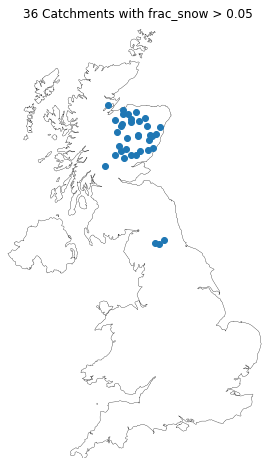

In [86]:
ax = initialise_gb_spatial_plot()
snowy_catchment_ids.plot(ax=ax)
N = len(snowy_catchment_ids)
ax.set_title(f"{N} Catchments with frac_snow > {snowy_threshold}");

# Check Cell State

In [87]:
snow_cell_states = [9, 8]
snow_dims = [f"dim{c}" for c in snow_cell_states]

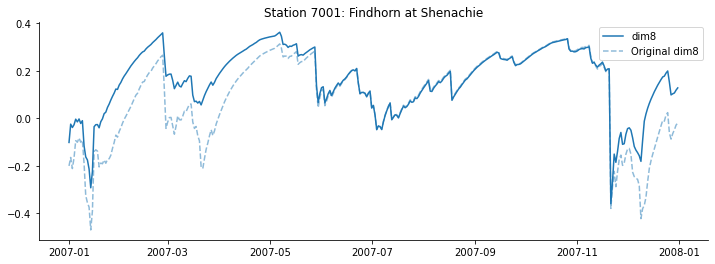

In [107]:
f, ax = plt.subplots(figsize=(12, 4))

px = np.random.choice(snowy_catchment_ids.index)
time_str = "2007"
# obs_data = era5_sm["sd"].sel(station_id=px, time=time_str)
# ax.plot(obs_data.time.values, obs_data.values, alpha=0.5, color="k", ls="--", label="ESA CCI SM Obs")

colors = ["C0", "C1"]
for ix, dim in enumerate(snow_dims[::-1]):
    data = cs.sel(station_id=px, time=time_str)
    og_data = og_cs.sel(station_id=px, time=time_str)
    ax.plot(data.time, data[dim], label=dim, color=colors[ix], alpha=1)
    ax.plot(data.time, og_data[dim], label=f"Original {dim}", ls="--", color=colors[ix], alpha=0.5)
    ax.set_title(f"Station {px}: {snowy_catchment_ids.loc[px].gauge_name}")
    ax.legend()
    sns.despine()
    break

# what impact on predictions in snowy catchments?

In [38]:
if not (run_dir / "errors_forced.nc").exists():
    if "errors_forced" not in globals():
        errors_forced = calculate_all_error_metrics(forced_pred, basin_coord="station_id", time_coord="date")
        errors_forced["station_id"] = errors_forced["station_id"].astype(int)
        errors_forced.to_netcdf(run_dir / "errors.nc")
    else:
        print("Already run errors!")
else:
    errors_forced = xr.open_dataset(run_dir / "errors_forced.nc")
errors = xr.open_dataset(run_dir / "errors.nc")

Already run errors!


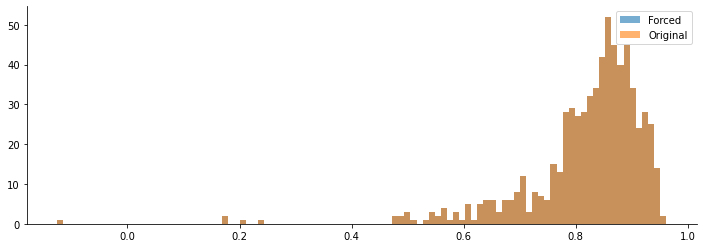

In [44]:
f, ax = plt.subplots(figsize=(12, 4))
plt.hist(errors_forced["NSE"], alpha=0.6, bins=100, label="Forced");
plt.hist(errors["NSE"], alpha=0.6, bins=100, label="Original");
plt.legend()
sns.despine()

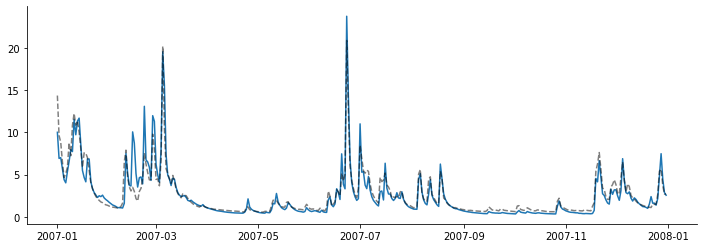

In [33]:
px = np.random.choice([str(i) for i in (snowy_catchment_ids.index)])
data = forced_pred.sel(date="2007", station_id=px)
f, ax = plt.subplots(figsize=(12, 4))
ax.plot(data["date"], data["discharge_spec_obs"], ls="-", label="Sim")
ax.plot(data["date"], data["discharge_spec_sim"], ls="--", alpha=0.5, color="k", label="Obs")
sns.despine()

# Train Linear Probe

In [34]:
if False:
    era5filepath = (data_dir / "camels_basin_ERA5Land_sm.nc")
    era5_sm = xr.open_dataset(era5filepath).drop("spatial_ref")


    from scripts.cell_state.normalize import normalize_2d_dataset

    if not isinstance(era5_sm, xr.Dataset):
        era5_sm = era5_sm.to_dataset()

    for var in era5_sm.data_vars:
        era5_sm[var] = normalize_2d_dataset(era5_sm, variable_str=var, per_basin=True)

In [35]:
if False:
    px = np.random.choice(snowy_catchment_ids.index)
    data = era5_sm["sd"].sel(station_id=px, time="2007")
    station = snowy_catchment_ids.loc[px]["gauge_name"]

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.values, ls="--", alpha=0.6, color="k")
    ax.set_ylabel("Snow Depth (m)");
    ax.set_title(f"{px}: {station}")
    sns.despine()

In [36]:
assert False

AssertionError: 

In [ ]:
from scripts.cell_state.sklearn_models import (
    init_linear_model,
    evaluate,
    create_analysis_dataset,
    fit_and_predict,
)
from scripts.cell_state.timeseries_dataset import TimeSeriesDataset, get_time_basin_aligned_dictionary
from collections import defaultdict

In [ ]:
target_ds = lognorm_p.to_dataset()
input_ds = cs

train_start_date: pd.Timestamp = pd.to_datetime("1998-01-01")
train_end_date: pd.Timestamp = pd.to_datetime("2006-09-30")
test_start_date: pd.Timestamp = pd.to_datetime("2006-10-01")
test_end_date: pd.Timestamp =  pd.to_datetime("2009-10-01")
seq_length = 1
basin_dim = "station_id"
time_dim = "time"
input_variables = [f"dim{i}" for i in np.arange(64)]
target_var = "snow_"

# train test split
target_data = target_ds.sel(time=slice(train_start_date, train_end_date))
input_data = input_ds.sel(time=slice(train_start_date, train_end_date))

test_target_data = target_ds.sel(time=slice(test_start_date, test_end_date))
test_input_data = input_ds.sel(time=slice(test_start_date, test_end_date))


# all_train_test = defaultdict(dict)
print(f"** STARTING {target_var} **")
train_dataset = TimeSeriesDataset(
    input_data=input_data,
    target_data=target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Train Samples",
)

train = get_time_basin_aligned_dictionary(train_dataset)

test_dataset = TimeSeriesDataset(
    input_data=test_input_data,
    target_data=test_target_data,
    target_variable=target_var,
    input_variables=input_variables,
    seq_length=seq_length,
    basin_dim=basin_dim,
    time_dim=time_dim,
    desc="Creating Test Samples",
)

test = get_time_basin_aligned_dictionary(test_dataset)

# all_train_test[target_var]["train"] = train
# all_train_test[target_var]["test"] = test

In [ ]:
print(f"** {target_var} **")
model, preds, errors = fit_and_predict(train, test, random_seed=100)

# Explore Results

In [ ]:
p = preds
time = "2007"

N = 1
pixels = np.random.choice(p.station_id.values, N, replace=False)

for px in pixels:
    data = preds.sel(station_id=px, time=time)

    f, ax = plt.subplots(figsize=(12, 4))
    ax.plot(data.time, data.obs, color="k", ls="--", alpha=0.3)
    ax.plot(data.time, data.sim, ls="-", alpha=0.6, label=f"{target_var}")
    ax.legend()
    sns.despine()

In [ ]:
f, ax = plt.subplots(figsize=(12, 4))

nse = errors["NSE"]
ax.hist(nse.where(nse > -1, -1), bins=100, density=True, label=f"{target_var}: {nse.median().values:.3f}", alpha=0.6);
ax.axvline(nse.median(), ls="--", alpha=0.5)    
plt.set_title("")
ax.set_xlim(-1, 1)
ax.legend()
sns.despine()

In [ ]:
from scripts.cell_state.analysis import get_model_weights, plot_weights

f, ax = plt.subplots(figsize=(12, 2))
w, b = get_model_weights(model)
plot_weights(np.abs(w), kwargs={"vmin": 0.0, "vmax": 0.3}, ax=ax, cbar=False)
ax.set_title(f"Target: {target_var}")
plt.tight_layout()